In [ ]:
# Install yfinance library
%pip install -q yfinance --upgrade --no-cache-dir
%pip install -q pandas==1.5.3

In [2]:
# Import the necessary libraries
import pandas as pd
import yfinance as yf
import bs4 as bs
import matplotlib.pyplot as plt
import warnings
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from lib.utils.helpers import get_stock_symbols, extract_numerical_columns, get_snp_companies, get_cols_to_be_divided_by_total_assets
from lib.utils.stocks import get_meta_data
warnings.filterwarnings("ignore")

In [3]:
stocks = pd.read_csv("./lib/quarterly_statements.csv",index_col=0, parse_dates=True)

In [4]:
# getting all top 1500 US companies 
stock_symbols = get_stock_symbols()

In [5]:
stocks = stocks.loc['2020-01-01':]
stocks = stocks.loc[stocks.ticker.isin(stock_symbols)]
stocks['end_of_quarter'] = stocks.index

In [ ]:
# meta_df = get_meta_data(stock_symbols=stock_symbols, stocks=stocks)
# meta_df.to_csv('meta_df_2020.csv', index=False)

In [ ]:
meta_df = pd.read_csv('meta_df_2020.csv')
meta_df.end_of_quarter = pd.to_datetime(meta_df.end_of_quarter)
df = pd.merge(stocks, meta_df, how='left', on=['ticker', 'end_of_quarter'])

In [8]:
# df.to_csv('stocks_processed_2020.csv', index=False)

In [224]:
df = pd.read_csv('stocks_processed_2020.csv')

##### From here downwards, all the cells are concatenated and we run experiments from 2021-07-01 to today

In [65]:
quartals = ['2021-07-01', '2021-10-01',
            '2022-01-01', '2022-04-01', '2022-07-01', '2022-10-01',
            '2023-01-01', '2023-04-01', '2023-07-01', '2023-10-01',
            '2024-01-01']
accuracies = {}
all_columns = ['Cash Growth', 'Debt Growth','Net Cash / Debt','Net Cash / Debt Growth','Net Cash Per Share','Book Value Per Share','Operating Cash Flow Growth',
                    'Share Issuance / Repurchase','Debt Issued / Paid','Free Cash Flow Growth','Free Cash Flow Margin','Free Cash Flow Per Share','Revenue Growth (YoY)',
                    'Interest Expense / Income','Other Expense / Income','Net Income Growth','Shares Change','EPS Growth','Free Cash Flow Per Share.1','Dividend Per Share',
                    'Dividend Growth','Gross Margin','Operating Margin','Profit Margin','Free Cash Flow Margin.1','Effective Tax Rate','EBITDA Margin','EBIT Margin',
                    'Market Cap Growth','PE Ratio','PS Ratio','PB Ratio','P/FCF Ratio','P/OCF Ratio','Debt / Equity Ratio','Quick Ratio','Current Ratio',
                    'Return on Capital (ROIC)','Dividend Yield','Payout Ratio','Buyback Yield / Dilution','Total Shareholder Return','ticker','Return on Equity (ROE)',
                    'Return on Assets (ROA)','Earnings Yield','FCF Yield','end_of_quarter','industry','sector','increase']
lag_columns = ['Cash Growth', 'Debt Growth','Net Cash / Debt','Net Cash / Debt Growth','Net Cash Per Share','Book Value Per Share','Operating Cash Flow Growth',
                    'Share Issuance / Repurchase','Debt Issued / Paid','Free Cash Flow Growth','Free Cash Flow Margin','Free Cash Flow Per Share','Revenue Growth (YoY)',
                    'Interest Expense / Income','Other Expense / Income','Net Income Growth','Shares Change','EPS Growth','Free Cash Flow Per Share.1','Dividend Per Share',
                    'Dividend Growth','Gross Margin','Operating Margin','Profit Margin','Free Cash Flow Margin.1','Effective Tax Rate','EBITDA Margin','EBIT Margin',
                    'Market Cap Growth','PE Ratio','PS Ratio','PB Ratio','P/FCF Ratio','P/OCF Ratio','Debt / Equity Ratio','Quick Ratio','Current Ratio',
                    'Return on Capital (ROIC)','Dividend Yield','Payout Ratio','Buyback Yield / Dilution','Total Shareholder Return','Return on Equity (ROE)',
                    'Return on Assets (ROA)','Earnings Yield','FCF Yield']
for quartal in range(1, len(quartals)):
    df = pd.read_csv('stocks_processed_2020.csv')
    final_gain = df[['ticker', 'end_of_quarter', 'increase']]
    
    # final_increase = df.loc[(df.end_of_quarter > quartals[quartal-1])].reset_index(drop=True).groupby('ticker', as_index=False)['increase'].sum()
    # remove commas from thousands, and replace values that have only '-' with nan
    tmp = df['end_of_quarter'].copy()
    for col in list(df.columns):
        try:
            df.loc[:, col] = df.loc[:, col].str.replace(',', '').replace(r'^-$', np.nan, regex=True)
        except:
            pass
    # all percentage columns, remove the percent sign
    percentage_columns = [col for col in df.columns if any(df[col].astype(str).str.contains('%'))]
    for col in percentage_columns:
        df.loc[:, col] = df.loc[:, col].str.replace('%', '')
    df['end_of_quarter'] = tmp
    # selecting only numerical features, we need them for normalization, etc. 'increase' is also a numerical, but we dont modify it since it is our target
    numerical_columns = extract_numerical_columns(df)
    # we take all data since 2021 (we skip earlier years due covid effects) 
    df['end_of_quarter'] = pd.to_datetime(df['end_of_quarter'])
    df['end_of_quarter'] = pd.to_datetime(df['end_of_quarter'])
    df['quarter_year'] = df['end_of_quarter'].dt.to_period('Q')
    # converting all numerical values from string to float
    df[numerical_columns] = df[numerical_columns].astype('float')
    _CALCULATED = 'calculated'
    # avoid inf, add 10e-5
    df[f'{_CALCULATED}Earnings Yield'] = 1 / (df['PE Ratio'].astype('float') + 10e-5)
    df[f'{_CALCULATED}Share Price'] = df['PE Ratio'].astype('float') * df['EPS (Basic)'].astype('float')
    df[f'{_CALCULATED}FCF Yield'] = df['Free Cash Flow Per Share'].astype('float')/ (df[f'{_CALCULATED}Share Price'].astype('float') + 10e-5)
    df[f'{_CALCULATED}DPS'] = -1* df[ 'Dividends Paid'].astype('float') / (df['Shares Outstanding (Basic)'].astype('float') + 10e-5)
    df[f'{_CALCULATED}Dividents'] = df[f'{_CALCULATED}DPS'].astype('float') * df['Shares Outstanding (Basic)'].astype('float')
    # Liquidity Ratios
    df[f'{_CALCULATED}current_ratio'] = df['Total Current Assets'] /(df['Total Current Liabilities']+ 10e-5)
    df[f'{_CALCULATED}quick_ratio'] = (df['Cash & Equivalents'] + df['Short-Term Investments'] + df['Receivables']) / (df['Total Current Liabilities']+ 10e-5)
    df[f'{_CALCULATED}cash_ratio'] = (df['Cash & Equivalents'] + df['Short-Term Investments']) / (df['Total Current Liabilities']+ 10e-5)
    df[f'{_CALCULATED}operating_profit_margin'] = (df['Operating Income'] / (df['Revenue']+ 10e-5)) * 100
    df[f'{_CALCULATED}inventory_turnover'] = df['Cost of Revenue'] / (df['Inventory']+ 10e-5)
    df[f'{_CALCULATED}accounts_receivable_turnover'] = df['Revenue'] / (df['Receivables']+ 10e-5)

    calculated_feats = [x for x in df.columns if _CALCULATED in x]
    for c in lag_columns + calculated_feats:
        df[c+'_lag1'] = df.groupby('ticker')[c].shift(-1)
        df[c+'_lag2'] = df.groupby('ticker')[c].shift(-2)
        df[c+'_lag3'] = df.groupby('ticker')[c].shift(-3)
        df[c+'_lag4'] = df.groupby('ticker')[c].shift(-4)
        df[c+"_c1"] = (df[c] - df[c+'_lag1']) / (df[c+'_lag1'] + 1e-3)
        df[c+"_c2"] = (df[c] - df[c+'_lag2']) / (df[c+'_lag2'] + 1e-3)
        df[c+"_c3"] = (df[c] - df[c+'_lag3']) / (df[c+'_lag3'] + 1e-3)
        df[c+"_c4"] = (df[c] - df[c+'_lag4']) / (df[c+'_lag4'] + 1e-3)
    df = df.loc[(df.end_of_quarter > pd.to_datetime(quartals[quartal]) - pd.DateOffset(months=18)) & (df.end_of_quarter < pd.to_datetime(quartals[quartal]))].reset_index(drop=True)
    # Mean normalization of all numerical values. As suggested by finance experts, we take the mean and the standard deviation of the industry per quarter for normalization
    numerical_columns.remove('increase') # removing the target variable, we dont want to normalize that value
    tmp = df[['increase']]
    df.drop(['increase'], axis=1, inplace=True)
    df_mean = df.groupby(['quarter_year', 'industry']).mean()
    df_std = df.groupby(['quarter_year', 'industry']).std()
    dff = pd.merge(left=df, right=df_mean, how='left', on=['quarter_year', 'industry'], suffixes=["", "_mean"])
    dff = pd.merge(left=dff, right=df_std, how='left', on=['quarter_year', 'industry'], suffixes=["", "_std"])
    dff = pd.concat([dff, tmp], axis=1)
    ########################
    for col in numerical_columns:
        # dff[col+"_norm"] = (dff[col] - dff[col + "_mean"]) / (dff[col + "_std"] + 1e-3)
        pass
    ########################
    df = dff
    df['increase'] = tmp

    # One hot encoding of industry, we skip encoding of sector since we have almost all NaNs there
    one_hot_encoded_industry = pd.get_dummies(df['industry'], prefix='industry')
    df = pd.concat([df, one_hot_encoded_industry], axis=1)
    df.drop(['industry', 'sector'], axis=1, inplace=True)
    
    
    df['increase_two_q'] = df.groupby('ticker')['increase'].shift(1)
    # df['increase_two_q'].fillna(0, inplace=True)
    df['increase'] = df['increase'] + df['increase_two_q']
    df.drop(['increase_two_q'], axis=1, inplace=True)
    # where target variable 'increase' does not exists, remove those rows
    df.dropna(axis=0, inplace=True, subset=['increase'])

    # train test split (we leave the last quarter for test)
    df_test = df.groupby('ticker', as_index=False).first()
    df_test_tmp = df_test
    df_train = df.loc[~df.end_of_quarter.isin(list(df_test.end_of_quarter.values))]
    y_train = df_train[['increase', 'ticker']]
    y_test = df_test[['increase', 'ticker']]
    df_test = df_test.drop(['ticker', 'end_of_quarter', 'increase', 'quarter_year'], axis=1)
    df_train = df_train.drop(['ticker', 'end_of_quarter', 'increase',  'quarter_year'], axis=1)
    # going from real valued 'increase' to classification problem
    y_train['increase_real_values'] = y_train.increase
    class_thresholds = [-0.1, 0.0, 0.1, 0.2]
    y_train.increase[y_train.increase_real_values >= class_thresholds[3]] = 4
    y_train.increase[(y_train.increase_real_values >= class_thresholds[2]) & (y_train.increase_real_values < class_thresholds[3])] = 3
    y_train.increase[(y_train.increase_real_values >= class_thresholds[1]) & (y_train.increase_real_values < class_thresholds[2])] = 2
    y_train.increase[(y_train.increase_real_values > class_thresholds[0]) & (y_train.increase_real_values < class_thresholds[1])] = 1
    y_train.increase[y_train.increase_real_values <= class_thresholds[0]] = 0
    # We fill all NaN values with maxint from numpy. Currently, we are not sure if this is financially correct (?)
    df_train.fillna(np.iinfo('int').max, inplace=True)
    print(df_train.shape)
    df_test.fillna(np.iinfo('int').max, inplace=True)
    # Assuming you have your features (x) and labels (y) ready, split the data.
    X_train, X_test, Y_train, Y_test = train_test_split(df_train, y_train, test_size=0.1, random_state=42)
    # We fit a classifier to predict the increase in percentage into the next Q
    rf_classifier = RandomForestClassifier(n_estimators=500, random_state=42, max_depth=50)#, class_weight=class_weights)
    # Fit the model to the training data
    rf_classifier.fit(X_train, Y_train.increase)
    # Predict on the test set just as sanity check
    rf_classifier.predict(X_test)
    ticker = Y_test.ticker
    p = pd.DataFrame({"ticker": ticker, "preds": rf_classifier.predict(X_test), "true": Y_test.increase, "increase": Y_test.increase_real_values})
    # Select the top K stocks that we would invest (still this data is older, just for sanity check and to check for underfitting)
    accuracy = accuracy_score(p.true, p.preds)
    proba = rf_classifier.predict_proba(df_test.loc[y_test.ticker.isin(get_snp_companies('500'))])[rf_classifier.predict(df_test.loc[y_test.ticker.isin(get_snp_companies('500'))])== np.max(rf_classifier.predict(df_test.loc[y_test.ticker.isin(get_snp_companies('500'))]))]
    # predicting on the SNP 500 stocks
    p = pd.DataFrame({"ticker": y_test.loc[y_test.ticker.isin(get_snp_companies('500'))].ticker, "preds": rf_classifier.predict(df_test.loc[y_test.ticker.isin(get_snp_companies('500'))]), "increase": y_test.increase.loc[y_test.ticker.isin(get_snp_companies('500'))]})
    # selecting the top K stocks we want to put money in
    p[p.preds == np.max(p.preds.values)]
    b = p[p.preds == np.max(p.preds.values)]
    b['proba'] = proba[:, int(np.max(p.preds.values))]
    p['increase_q'] = p.increase
    class_thresholds = [-0.1, 0.0, 0.1, 0.2]
    p.increase_q[p.increase >= class_thresholds[3]] = 4
    p.increase_q[(p.increase >= class_thresholds[2]) & (p.increase < class_thresholds[3])] = 3
    p.increase_q[(p.increase >= class_thresholds[1]) & (p.increase < class_thresholds[2])] = 2
    p.increase_q[(p.increase > class_thresholds[0]) & (p.increase < class_thresholds[1])] = 1
    p.increase_q[p.increase <= class_thresholds[0]] = 0
    # Compute accuracy on test
    test_accuracy = accuracy_score(p.increase_q, p.preds)



    accuracies[quartals[quartal]] = {"val":accuracy, "test": test_accuracy, "gain": f'{b.sort_values(by="proba")[::-1].iloc[:5].increase.mean()  * 100}%',
                           "data": b.sort_values(by="proba")[::-1].iloc[:5]}
    final_gain.end_of_quarter = pd.to_datetime(final_gain.end_of_quarter)
    a = df_test_tmp[['ticker', 'end_of_quarter', 'increase']].loc[df_test_tmp.ticker.isin(accuracies[quartals[quartal]]['data'].ticker)]
    f_gain = {}
    for tick in a.ticker:
        aa = final_gain[final_gain.ticker == tick]
        f_gain[tick] = aa[aa.end_of_quarter >= df_test_tmp.loc[df_test_tmp.ticker == tick].end_of_quarter.values[0]].increase.sum()

    suma = 0
    for k in f_gain:
        suma += f_gain[k]
    
    accuracies[quartals[quartal]]["f_gain_percent"] = (suma * 100 / len(f_gain))
    accuracies[quartals[quartal]]["f_gain"] = f_gain
    print(quartals[quartal], accuracies[quartals[quartal]])
    print("######################")

    # add final gain and stock tickers with probabilitiess

(4494, 1964)
2021-10-01 {'val': 0.5911111111111111, 'test': 0.24363386097728837, 'gain': '19.00308990861268%', 'data':      ticker  preds  increase  proba
38      AFL    4.0  0.122786  0.582
1364   VREX    4.0  0.258937  0.556
1281    TPR    4.0  0.018215  0.534
119     ASO    4.0  0.352027  0.532
705     JEF    4.0  0.198191  0.530, 'f_gain_percent': 43.65628780502397, 'f_gain': {'AFL': 0.6372601762659545, 'ASO': 0.9298868286360062, 'JEF': 0.41280864590206334, 'TPR': 0.28360695060149527, 'VREX': -0.08074821115432099}}
######################
(5667, 1964)
2022-01-01 {'val': 0.49382716049382713, 'test': 0.26229508196721313, 'gain': '21.926470633929952%', 'data':      ticker  preds  increase  proba
933     NSA    4.0  0.239074  0.612
674    IIPR    4.0 -0.085890  0.598
1042    PLD    4.0  0.317091  0.586
483     EXR    4.0  0.271373  0.578
1107   REXR    4.0  0.354675  0.568, 'f_gain_percent': -8.713610382285035, 'f_gain': {'EXR': -0.014354554717090462, 'IIPR': -0.4262472032989281, 'NSA':

In [205]:
suma =  0
capital = 1000
start_capital = capital
for k in accuracies:
    suma += float(accuracies[k]['gain'][:-1])
    capital += capital * float(accuracies[k]['gain'][:-1]) / 100

print("The summed gain over the quartals is: ", suma, "%")
print(f'Starting with {start_capital} USD, over {len(accuracies)} quartals, we will end up with {capital} USD')

suma =  0
capital = 1000
reinvestment_every_quartal = 2100
start_capital = capital
for k in accuracies:
    suma += float(accuracies[k]['gain'][:-1])
    capital += capital * float(accuracies[k]['gain'][:-1]) / 100 + reinvestment_every_quartal

print(f'Starting with {start_capital} USD, over {len(accuracies)} quartals, if we add {reinvestment_every_quartal} USD plus every quartal, we will end up with {capital} USD')
print(f'Out of {capital} USD, our investment accounts {start_capital + reinvestment_every_quartal *len(accuracies)}, while the gain accounts for {capital - (start_capital + reinvestment_every_quartal *len(accuracies))}')



The summed gain over the quartals is:  143.89431114654695 %
Starting with 1000 USD, over 10 quartals, we will end up with 3210.857921939168 USD
Starting with 1000 USD, over 10 quartals, if we add 2100 USD plus every quartal, we will end up with 58098.221160402754 USD
Out of 58098.221160402754 USD, our investment accounts 22000, while the gain accounts for 36098.221160402754


In [63]:
ss = 0
for q in accuracies:
    ss += accuracies[q]['f_gain_percent']

ss/len(accuracies)

31.877615840423765

1385


<Figure size 3200x1000 with 0 Axes>

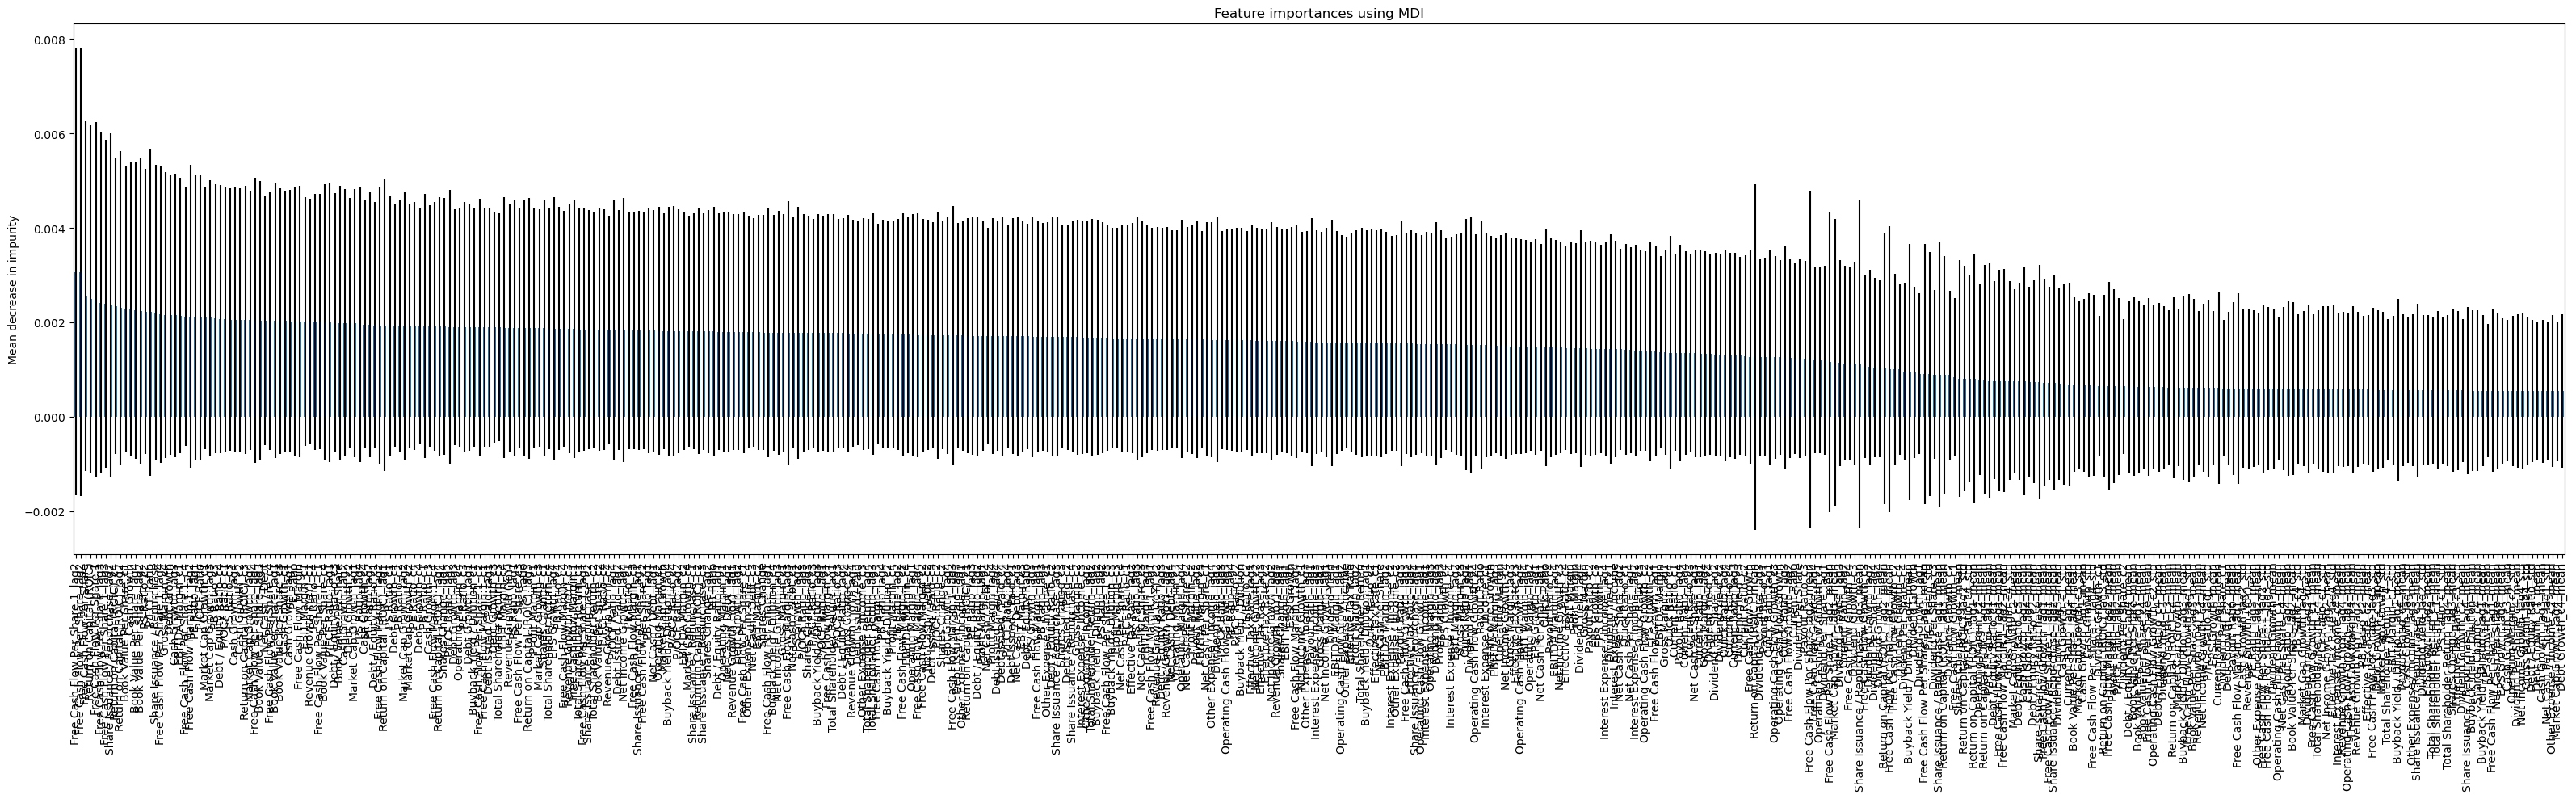

In [192]:
importances = rf_classifier.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_classifier.estimators_], axis=0)
print(len(importances))
forest_importances = pd.DataFrame({"importances": importances, "std": std}, index=list(df_train.columns))
forest_importances = forest_importances.sort_values(by='importances', ascending=False)[:500]
plt.figure(figsize=(32,10))
fig, ax = plt.subplots(figsize=(32,10))
forest_importances.importances.plot.bar(yerr=forest_importances['std'].values, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.savefig('feature_importances_plot.png', dpi=600)